# Report 02
### Daniel Bishop

License: Attribution 4.0 International (CC BY 4.0) 

In [1]:
from thinkbayes2 import Pmf, Suite, Joint
% matplotlib inline

## Extended Kim Rhode Problem
#### Chapter 5
Given that two skeet shooters tied in their regulation rounds and then went to four rounds of sudden death, what are their accuracies?

In [2]:
from thinkbayes2 import MakeBinomialPmf

class ShooterPair(Suite):
    # hypo = (accuracy of Rhode, accuracy of Wei)
    # data = (tied in regulation, ties in overtime...)
    
    def Likelihood(self, data, hypo):
        r = MakeBinomialPmf(25, hypo[0])
        w = MakeBinomialPmf(25, hypo[1])
        if (data[0] == "tied"):
            prob = 1 - r.ProbGreater(w) - r.ProbLess(w) # the probability of a tie
        else:
            prob = r.ProbGreater(w) + r.ProbLess(w) # the probability of a not tie
            
        r = MakeBinomialPmf(2, hypo[0])
        w = MakeBinomialPmf(2, hypo[1])
        for overtime in data[1:]:
            if (overtime == "tied"):
                prob *= 1 - r.ProbGreater(w) - r.ProbLess(w) # the probability of a tie
            else:
                prob *= r.ProbGreater(w) + r.ProbLess(w) # the probability of a not tie
                
        return prob

In [3]:
from itertools import product
import thinkplot
import numpy as np

x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
pmf = ShooterPair(list(product(x, y)))
pmf.Update(['tied', 'tied', 'tied', 'tied', 'won'])
pmf.Print()

(0.0, 0.0) 0.0
(0.0, 0.052631578947368418) 0.0234074909509
(0.0, 0.10526315789473684) 0.00774380736731
(0.0, 0.15789473684210525) 0.00172430561844
(0.0, 0.21052631578947367) 0.00030204623108
(0.0, 0.26315789473684209) 4.31676624601e-05
(0.0, 0.31578947368421051) 5.04952622561e-06
(0.0, 0.36842105263157893) 4.77291657398e-07
(0.0, 0.42105263157894735) 3.5570499565e-08
(0.0, 0.47368421052631576) 2.01532922461e-09
(0.0, 0.52631578947368418) 8.24862387539e-11
(0.0, 0.57894736842105265) 2.27120468006e-12
(0.0, 0.63157894736842102) 3.80160132464e-14
(0.0, 0.68421052631578938) 3.35382057529e-16
(0.0, 0.73684210526315785) 2.38775572268e-18
(0.0, 0.78947368421052633) 3.38264197177e-19
(0.0, 0.84210526315789469) 6.96153232966e-20
(0.0, 0.89473684210526305) 6.19844629428e-21
(0.0, 0.94736842105263153) 7.46846902734e-23
(0.0, 1.0) 0.0
(0.052631578947368418, 0.0) 0.0234074909509
(0.052631578947368418, 0.052631578947368418) 0.0323742869268
(0.052631578947368418, 0.10526315789473684) 0.0221372075793


Here we can see that every possible combination of accuracies between the two shooters has a corresponding likelihood. Notable, there is a 0 likelihood of both shooters being perfectly accurate or innacturate, since one of them did end up shooting more than the other in order to win the last overtime match. It is also impossible for either one of them to have 100% accuracy while the other has 0% because they would never tie.

In [4]:
from operator import itemgetter

max(pmf.Items(), key=itemgetter(1))

((0.052631578947368418, 0.052631578947368418), 0.032374286926815203)

The accuracy combination with the highest likelihood is that both shooters are 5.2% accurate. This would seem to imply that the most likely outcome is that both shooter missed every shot until the very last overtime where one of them hit one.

## The GPS Problem
#### From Chapter 9 of ThinkBayes

> GPS included a (currently disabled) feature called Selective Availability (SA) that adds intentional, time varying errors of up to 100 meters (328 ft) to the publicly available navigation signals. This was intended to deny an enemy the use of civilian GPS receivers for precision weapon guidance.
> [...]
> Before it was turned off on May 2, 2000, typical SA errors were about 50 m (164 ft) horizontally and about 100 m (328 ft) vertically.[10] Because SA affects every GPS receiver in a given area almost equally, a fixed station with an accurately known position can measure the SA error values and transmit them to the local GPS receivers so they may correct their position fixes. This is called Differential GPS or DGPS. DGPS also corrects for several other important sources of GPS errors, particularly ionospheric delay, so it continues to be widely used even though SA has been turned off. The ineffectiveness of SA in the face of widely available DGPS was a common argument for turning off SA, and this was finally done by order of President Clinton in 2000.

Suppose it is 1 May 2000, and you are standing in a field that is 200m square.  You are holding a GPS unit that indicates that your location is 51m north and 15m west of a known reference point in the middle of the field.

However, you know that each of these coordinates has been perturbed by a "feature" that adds random errors with mean 0 and standard deviation 30m.

1) After taking one measurement, what should you believe about your position?

Note: Since the intentional errors are independent, you could solve this problem independently for X and Y.  But we'll treat it as a two-dimensional problem, partly for practice and partly to see how we could extend the solution to handle dependent errors.

You can start with the code in gps.py.

2) Suppose that after one second the GPS updates your position and reports coordinates (48, 90).  What should you believe now?

3) Suppose you take 8 more measurements and get:

    (11.903060613102866, 19.79168669735705)
    (77.10743601503178, 39.87062906535289)
    (80.16596823095534, -12.797927542984425)
    (67.38157493119053, 83.52841028148538)
    (89.43965206875271, 20.52141889230797)
    (58.794021026248245, 30.23054016065644)
    (2.5844401241265302, 51.012041625783766)
    (45.58108994142448, 3.5718287379754585)

At this point, how certain are you about your location?

In [5]:
from scipy.stats import norm

class Gps(Suite, Joint):
    def Likelihood(self, data, hypo):
        # hypo = supposed (x,y) position
        # data = reported (x,y) position
        std = 30 # given by problem
        
        # what is the likelihood that we are at the hypo position if the data says we are at some other position?
        # calc x and y seperately
        prob = norm.pdf(data[0], hypo[0], 30)
        prob *= norm.pdf(data[1], hypo[1], 30)
        return prob

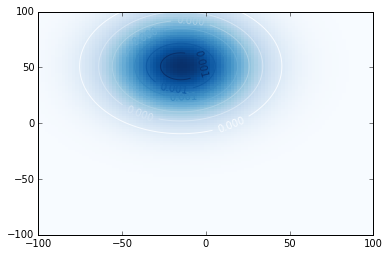

In [6]:
pmf = Gps(product(np.linspace(-100, 100, 100), np.linspace(-100, 100, 100)))
pmf.Update((-15, 51))
thinkplot.Contour(pmf, pcolor=True)

So after the intial reading, we know that we must be somewhere in te area northwest of the center, but we don't know exactly where.

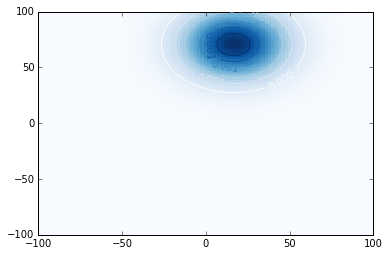

In [7]:
pmf.Update((48, 90))
thinkplot.Contour(pmf, pcolor=True)

With the second reading, we are zeroing in on our position, and it looks like we are north and slightly east of the center.

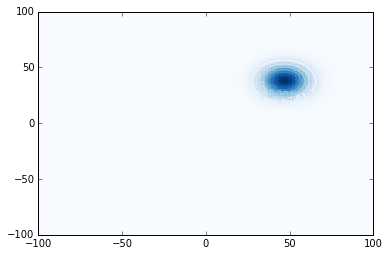

In [8]:
data = [(11.903060613102866, 19.79168669735705),
        (77.10743601503178, 39.87062906535289),
        (80.16596823095534, -12.797927542984425),
        (67.38157493119053, 83.52841028148538),
        (89.43965206875271, 20.52141889230797),
        (58.794021026248245, 30.23054016065644),
        (2.5844401241265302, 51.012041625783766),
        (45.58108994142448, 3.5718287379754585)]

for d in data:
    pmf.Update(d)
    
thinkplot.Contour(pmf, pcolor=True)

After taking multiple readings, we are fairly sure of our location and that we are northeast of the center. We have narrowed down our location to a circle with a diameter of about 20 meters.

## Original Problem: German Subs

Suppose that you have a bunch of identical listening stations in the ocean, and that when a sub comes within 50 meters of the station, then it is detected. however, the stations are unreliable, and only have a small chance to detect a sub at the max range of 50 meters. The chance of detecting the sub increases as the distance to the station decreases. To solve this, listening stations are placed in patterns such that their areas of detection overlap, and they can triangulate a sub's position by combining all of their data. 

Suppose you have 5 listening stations at positions at:

    (0, 0)
    (25, 25)
    (-25, -25)
    (-25, 25)
    (25, -25)
    
Where is the sub if only station 1 (the first one) detects it?

In [9]:
from thinkbayes2 import EvalNormalPdf

class Network(Suite, Joint):
    stations = {
        1: (0, 0),
        2: (25, 25),
        3: (-25, -25),
        4: (-25, 25),
        5: (25, -25)
    }
    
    def Likelihood(self, data, hypo):
        # hypo = pos of sub
        # data = set of all stations and whether they see the sub or not
        
        
        # std of 8 makes the distribution go from roughly -25 to 25 representing the 50 meter wide circle
        prob = 1
        for d in data:
            station = d[0]
            seesSub = d[1]
            sx, sy = self.stations[station] # station x and y coords
            sp = EvalNormalPdf(sx, hypo[0], 8)
            sp *= EvalNormalPdf(sy, hypo[1], 8)
            if (seesSub):
                prob *= sp
            else:
                prob *= (1 - sp)
        
        return prob

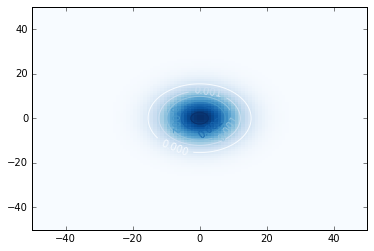

In [10]:
pmf = Network(product(np.linspace(-50, 50, 100), np.linspace(-50, 50, 100)))
pmf.Update([(1, True), (2, False), (3, False), (4, False), (5, False)])
thinkplot.Contour(pmf, pcolor=True)

Here we can see that the sub is likely somewhere around station 1, with a higher probability of it being closer to the station as that's where the station has a higher likelihood of detecting it.

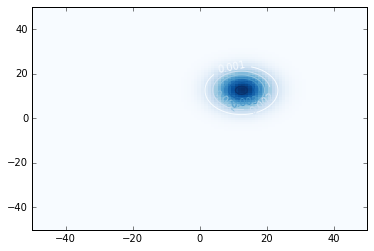

In [14]:
pmf = Network(product(np.linspace(-50, 50, 100), np.linspace(-50, 50, 100)))
pmf.Update([(1, True), (2, True), (3, False), (4, False), (5, False)])
thinkplot.Contour(pmf, pcolor=True)

If station 2 (located at 25, 25) detects a sub too, then the probable location of the sub shifts to somewhere between stations 1 and 2.

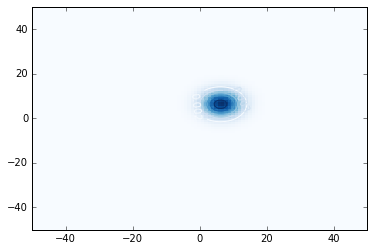

In [15]:
pmf.Update([(1, False), (2, False), (3, False), (4, True), (5, True)])
thinkplot.Contour(pmf, pcolor=True)

If suddenly only stations 4 and 5 can see a sub, then we still think the sub is over by stations 1 and 2, but that they are just failing to detect it.

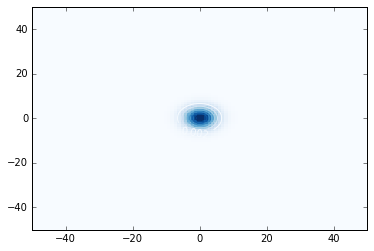

In [16]:
for i in range(3):
    pmf.Update([(1, False), (2, False), (3, False), (4, True), (5, True)])
thinkplot.Contour(pmf, pcolor=True)

However, as we get more reports that only stations 4 and 5 can see the sub, the predicted location of the sub starts to drift over to 4 and 5. By continuously updating the model with reports from all the stations, the location of the sub can be tracked over time.

## Project Update

My partner and I would like to work on a survival analysis problem